In [3]:
import math

import matplotlib.pyplot as plt
import numpy as np
% load_ext autoreload
% autoreload 2

In [4]:
from keras.models import load_model

import matplotlib.pyplot as plt

import tifffile
import os

In [5]:
eval_folder_list = ["../jupyter_data/eval/c1", "../jupyter_data/eval/c2", "../jupyter_data/eval/c3"]


In [6]:
from read_roi import read_roi_zip


def read_roi(roi_path):
    roi = read_roi_zip(roi_path)
    roi_coords = []
    for i, v in enumerate(roi.values()):
        if v['type'] == 'rectangle':
            roi_x, roi_y = v['left'], v['top']
            roi_width, roi_height = v['width'], v['height']
            roi_coords.append([roi_x, roi_y, roi_width, roi_height])
    return roi_coords


In [7]:
eval_data_list = []
eval_tifpath_list = []
for channel_folder in eval_folder_list:
    for folder in os.listdir(channel_folder):
        image_folder = os.path.join(channel_folder, folder)
        files_list = os.listdir(image_folder)
        files_list = [os.path.join(image_folder, file) for file in files_list]
        if len(files_list) != 2:
            print("Number of files is not 2.")
            continue
        golgi_dict = {}
        if files_list[0].endswith("tif"):
            tif_path, roi_path = files_list
        else:
            roi_path, tif_path = files_list
        eval_tifpath_list.append(tif_path)

        giantin_channel = int(channel_folder[-1]) - 1
        golgi_image = tifffile.imread(tif_path)
        golgi_dict['golgi_image'] = golgi_image
        golgi_dict['giantin_channel'] = giantin_channel
        golgi_dict['roi_coords'] = read_roi(roi_path)

        eval_data_list.append(golgi_dict)
    print("Got {} golgi images.".format(len(eval_data_list)))

Got 7 golgi images.
Number of files is not 2.
Got 14 golgi images.
Got 15 golgi images.


In [8]:
from train_src.metrics import *

# load model

model_path = "../model/valDice0.6752_valMeanIoU0.5303.h5"
model_path = "../model/valDice0.6965_valMeanIoU0.5542.h5"
model_path = "../model/valDice0.7042_valMeanIoU0.5532.h5"
model = load_model(model_path, compile=False)
model.compile(loss=bce_dice_loss,
              metrics=["binary_crossentropy", mean_iou, dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv11_1 (Conv2D)               (None, 256, 256, 32) 320         input[0][0]                      
__________________________________________________________________________________________________
bn11_1 (BatchNormalization)     (None, 256, 256, 32) 128         conv11_1[0][0]                   
__________________________________________________________________________________________________
relu11_1 (Activation)           (None, 256, 256, 32) 0           bn11_1[0][0]                     
______________________________________________________________________________________________

In [9]:
giantin_tif_list = []
golgi_image_list = []

for data in eval_data_list:
    golgi_image = data['golgi_image']
    giantin_channel = data['giantin_channel']
    giantin_tif = golgi_image[giantin_channel]
    giantin_tif_list.append(giantin_tif)
    golgi_image_list.append(golgi_image)

In [10]:
from jupyter_src.functions import padding_image

padded_giantin_list, patches_giantin_list = padding_image(giantin_tif_list, do_patchify=True,
                                                          clear_edge_roi=False, patch_size=(256, 256),
                                                          patch_step=206)

668
874
1080
668
1080
1080
1080
668
1080
874
1080
874
1492
874
668


In [11]:
from jupyter_src.functions import get_img_unpad

unpadded_test = get_img_unpad(padded_giantin_list[0], 78)

In [12]:
import numpy as np

np.equal(unpadded_test, giantin_tif_list[0]).all()

True

In [13]:
from jupyter_src.functions import make_model_input

X_eval, num_patches_perimage = make_model_input(patches_giantin_list, do_norm=True, data_shape=(-1, 256, 256, 1))

In [14]:
pred = model.predict(X_eval, verbose=1)

10/10 [==============================] - 26s 3s/step


In [15]:
from jupyter_src.functions import pred_to_mask, unpadding_image

pred_mask, pred_mask_patches = pred_to_mask(pred, num_patches_perimage)
unpad_mask_list = unpadding_image(pred_mask, giantin_tif_list)

In [16]:
threshold = 0.5

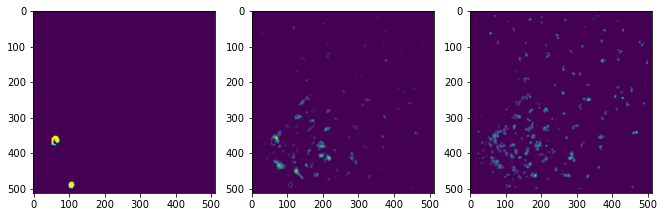

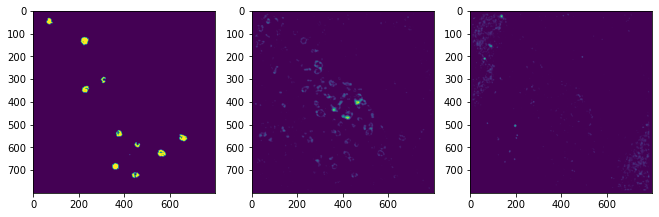

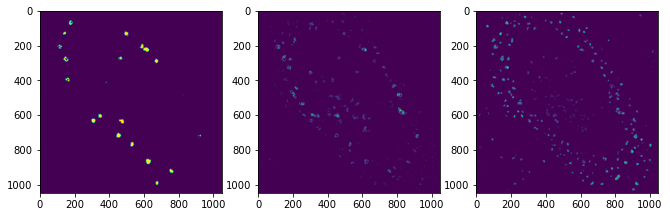

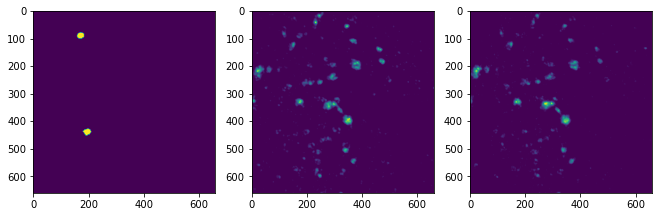

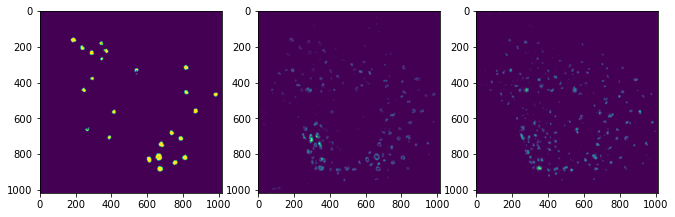

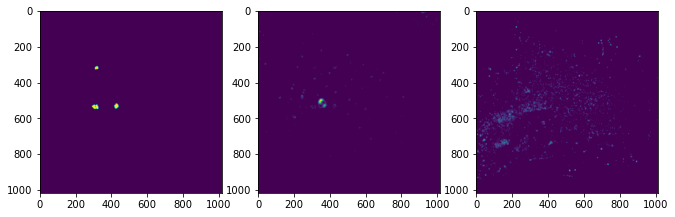

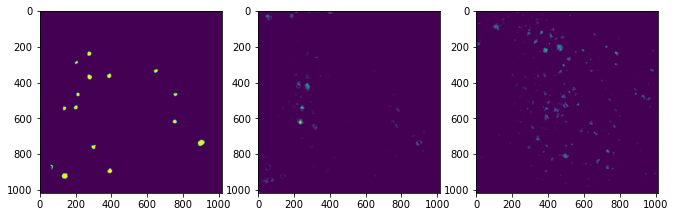

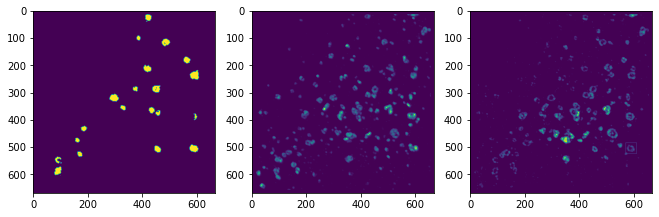

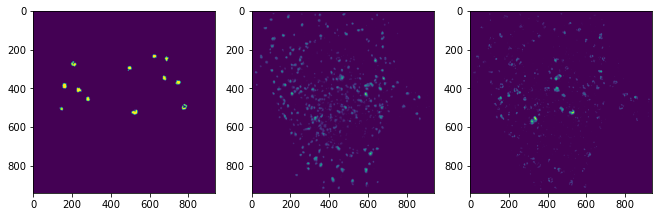

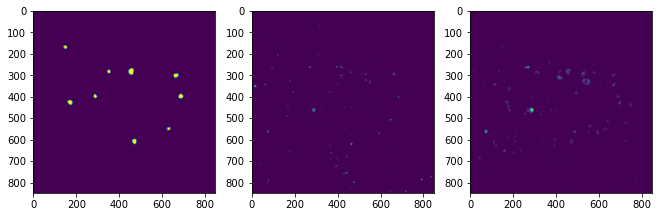

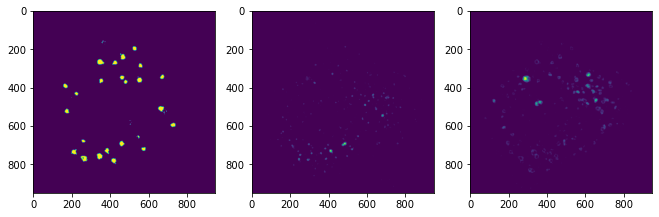

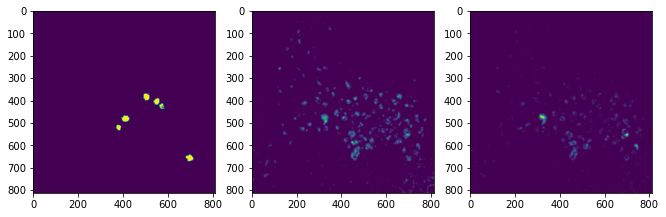

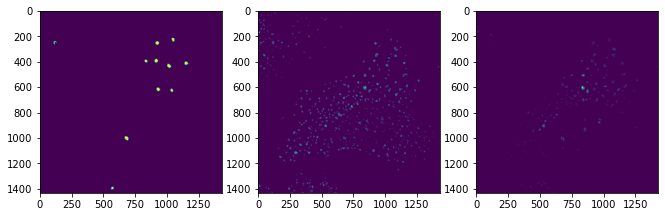

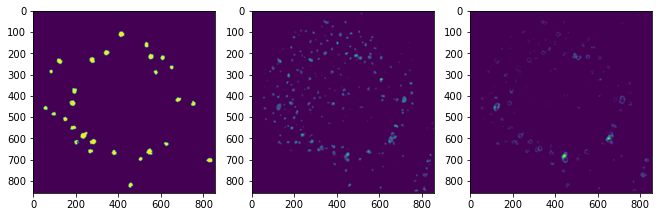

In [17]:
# show mask, raw giantin and normalzed giantin
import tensorflow as tf

for k in range(len(pred_mask) - 1):
    golgi = tf.keras.utils.normalize(golgi_image_list[k], axis=1)
    plt.figure(figsize=(15, 15))
    plt.subplot(141)
    plt.imshow(np.array(unpad_mask_list[k] > threshold, dtype=np.bool_))
    plt.subplot(142)
    plt.imshow(golgi_image_list[k][0])
    plt.subplot(143)
    plt.imshow(golgi_image_list[k][1])
    if golgi.shape[2] == 3:
        plt.subplot(144)
        plt.imshow(golgi_image_list[k][2])

    plt.show()

../jupyter_data/eval/c1\20191114-Giantin-594-Cab45-myc-488-Noc-03\20191114-Giantin-594-Cab45-myc-488-Noc-03_BGST.tif


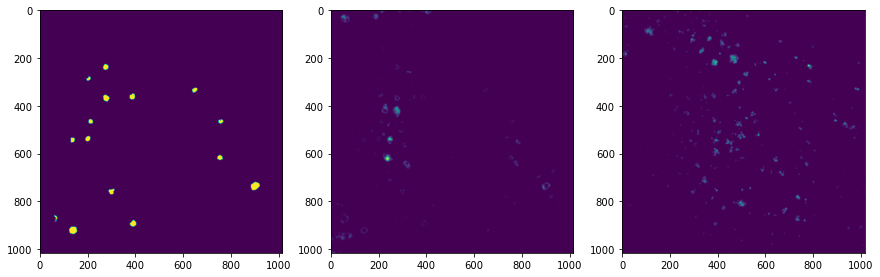

In [168]:
k = 6
print(eval_tifpath_list[k])
golgi = tf.keras.utils.normalize(golgi_image_list[k], axis=1)
plt.figure(figsize=(20, 5))
plt.subplot(141)
plt.imshow(np.array(unpad_mask_list[k] > threshold, dtype=np.bool_))
plt.subplot(142)
plt.imshow(golgi_image_list[k][0])
plt.subplot(143)
plt.imshow(golgi_image_list[k][1])

## deal with mask

In [17]:
threshold = 0.5

../jupyter_data/eval/c1\20181025-VSVGwt-Flag-594-ST6-moxGFP-5mBiotin-Noc-03\20181025-Giantin-647-RUSH-VSVGwt-Flag-594-ST6-moxGFP-5mBiotin-Noc-03.tif


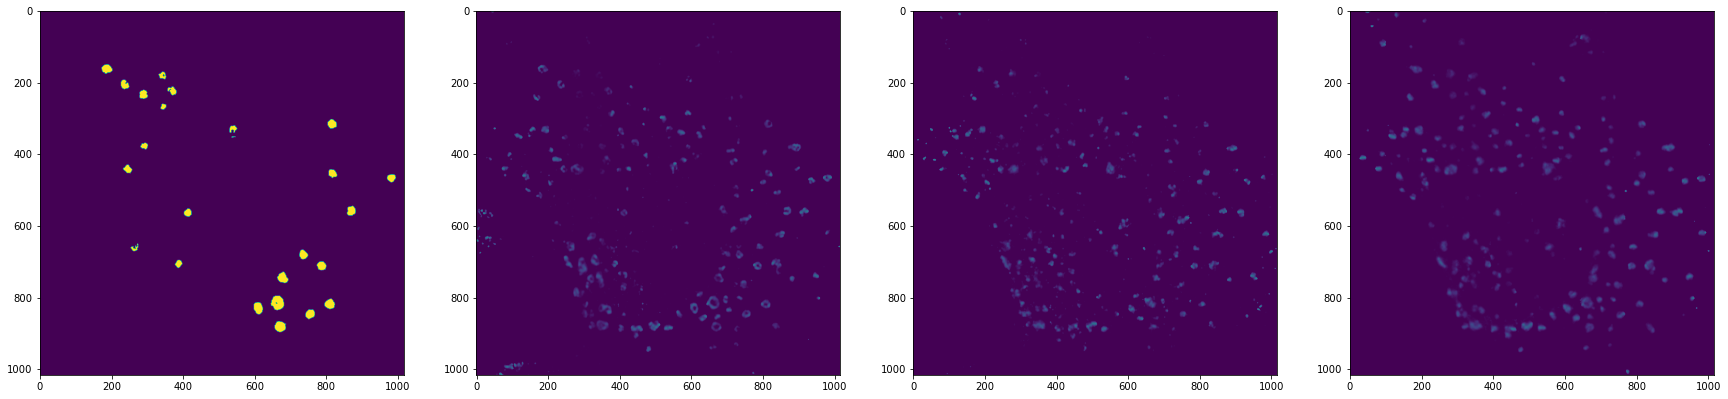

In [18]:
k = 1
print(eval_tifpath_list[k])
thres_mask = np.array(unpad_mask_list[k] > threshold, dtype=np.uint8)
golgi = tf.keras.utils.normalize(golgi_image_list[k], axis=1)
# golgi = golgi_image_list[k]
plt.figure(figsize=(30, 10))
plt.subplot(141)
plt.imshow(thres_mask)
plt.subplot(142)
plt.imshow(golgi[0])
plt.subplot(143)
plt.imshow(golgi[1])
if golgi_image_list[k].shape[0] == 3:
    plt.subplot(144)
    plt.imshow(golgi[2])

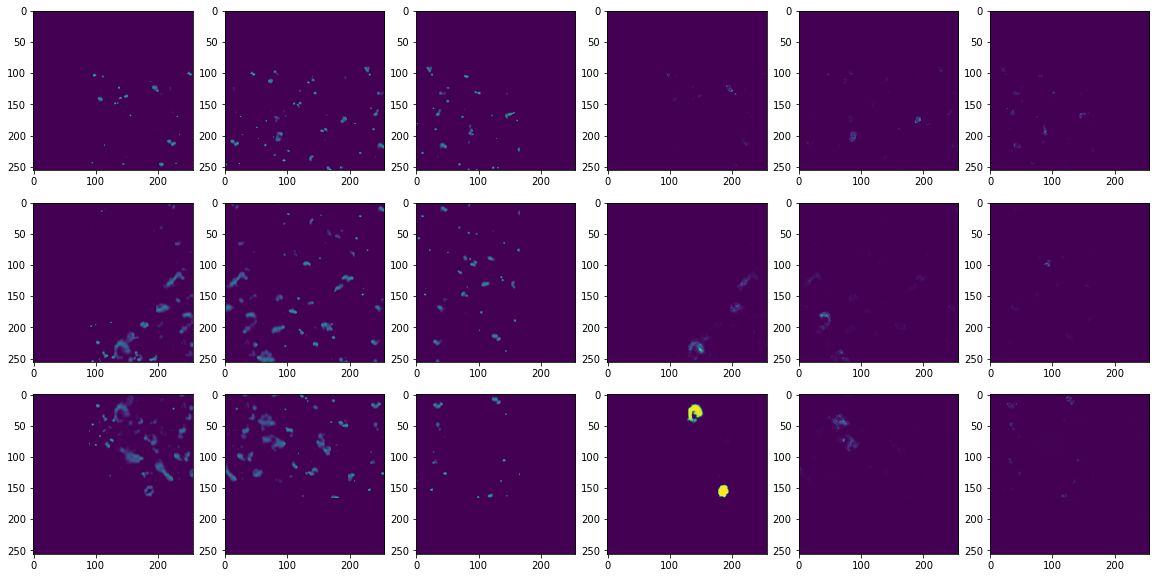

In [108]:
test_giantin_patches = tf.keras.utils.normalize(patches_giantin_list[k], axis=1)
test_pred_mask_patches = pred_mask_patches[k]
nrow = int(np.sqrt(test_giantin_patches.shape[0]))
plt.figure(figsize=(20, 10))

for i, patch in enumerate(test_giantin_patches):
    pos = i // nrow * nrow + i + 1
    plt.subplot(nrow, 2 * nrow, pos)
    plt.imshow(patch)

    plt.subplot(nrow, 2 * nrow, pos + nrow)
    plt.imshow(test_pred_mask_patches[i])

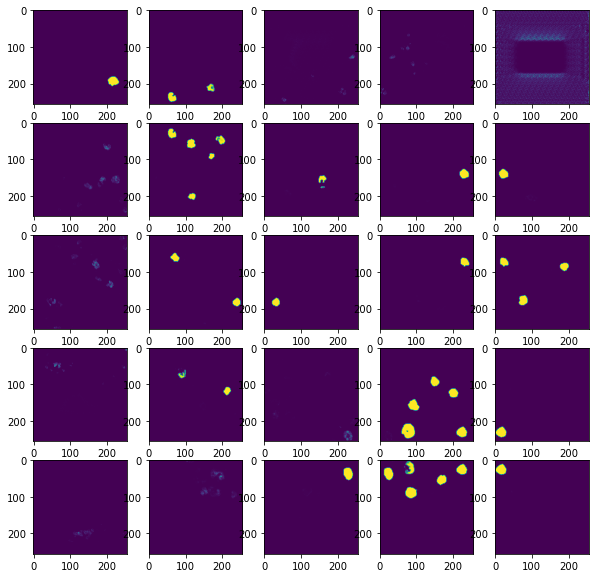

In [122]:
test_pred_mask_patches = pred_mask_patches[k]
nrow = int(np.sqrt(test_pred_mask_patches.shape[0]))
plt.figure(figsize=(10, 10))

for i, patch in enumerate(test_pred_mask_patches):
    plt.subplot(nrow, nrow, i + 1)
    plt.imshow(patch)

## find contours on mask

In [231]:
threshold = 0.5
k = 2
thres_mask = np.array(unpad_mask_list[k] > threshold, dtype=np.uint8)

In [232]:
import cv2

In [233]:
contours, _ = cv2.findContours(thres_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [234]:
contour_area_threshold = 150
giantin_possibility_threshold = 0.6
giantin_channel = 0

0
666 979


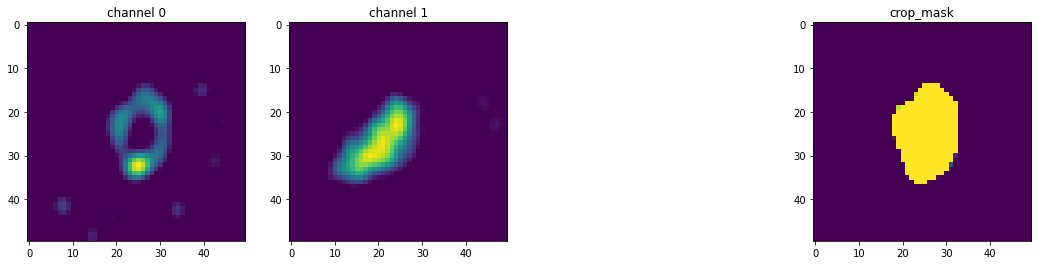

Circle match: 0.07994021744006807
circularity is 0.7817598710595909
ratio of minAreaRect :0.6363636363636364
ratio of minEnclosingCircle :0.5765747073071569
ratio of boundingRect :0.6681159420289855
circle: 0.07994021744006807
ellipse: 0.1398613484116844


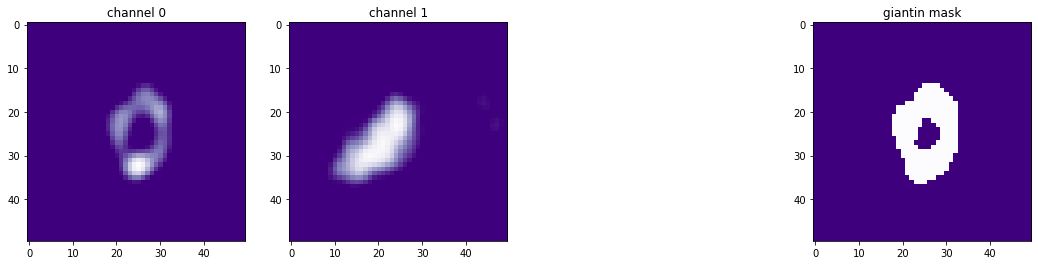

new rect_size: 48
666 979


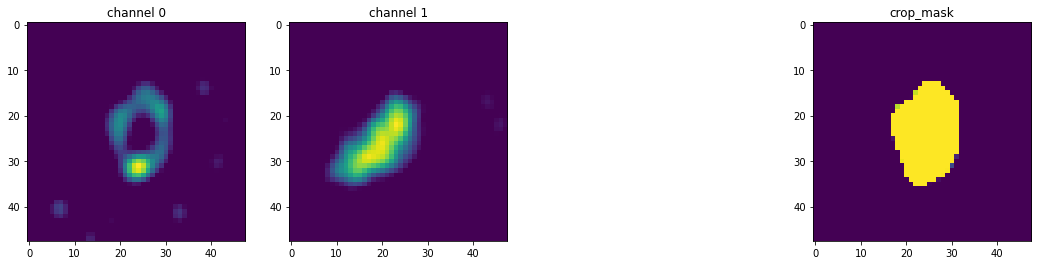

Circle match: 0.0799402174400703
circularity is 0.7817598710595909
ratio of minAreaRect :0.6363636363636364
ratio of minEnclosingCircle :0.5765747073071569
ratio of boundingRect :0.6681159420289855
circle: 0.0799402174400703
ellipse: 0.1398613484116834


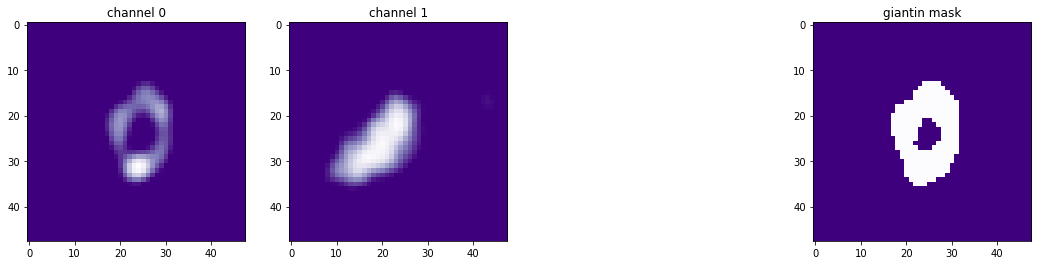

(349.5138, 349.5112)
1
746 909


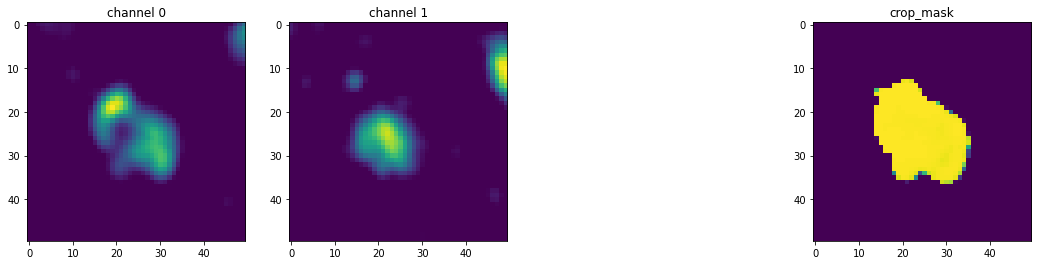

crop had convex, and not satisfied.


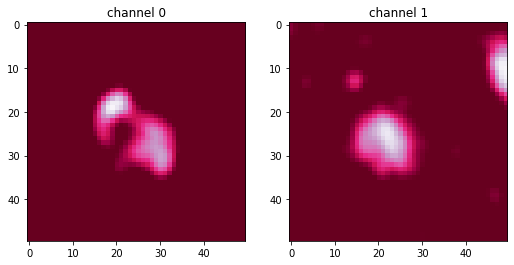

2
610 851


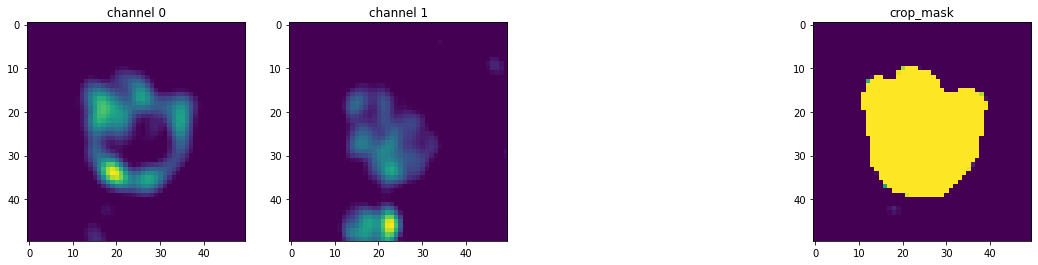

Circle match: 0.023406839770279575
circularity is 0.7488390667711061
ratio of minAreaRect :0.9655172413793104
ratio of minEnclosingCircle :0.7400374444003912
ratio of boundingRect :0.6908045977011494
circle: 0.023406839770279575
ellipse: 0.3678860475173118


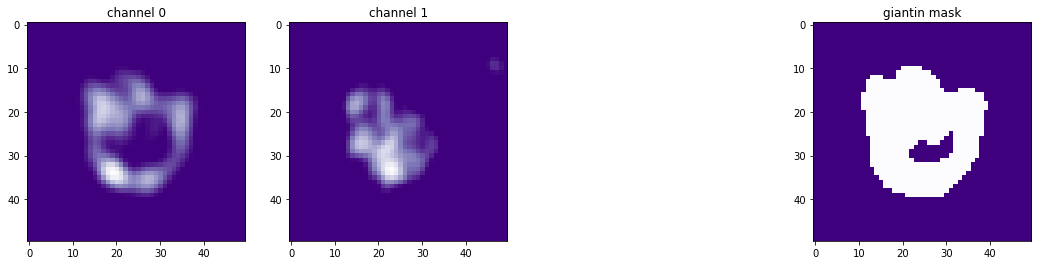

(349.4985, 349.5042)
3
521 755


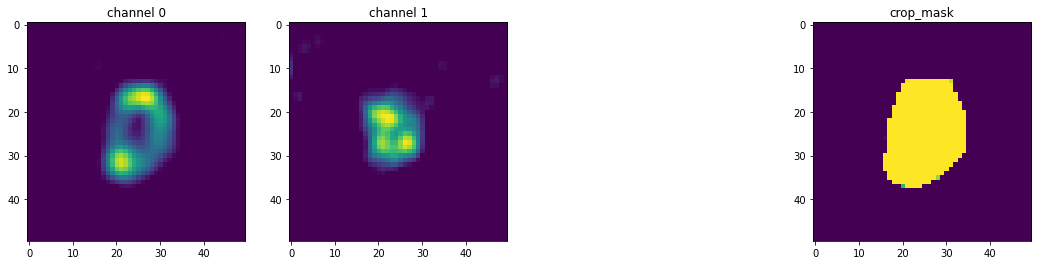

Circle match: 0.08303963718786456
circularity is 0.7951218619087295
ratio of minAreaRect :0.6956521739130435
ratio of minEnclosingCircle :0.6123784066264767
ratio of boundingRect :0.6813725490196079
circle: 0.08303963718786456
ellipse: 0.13200424462783567


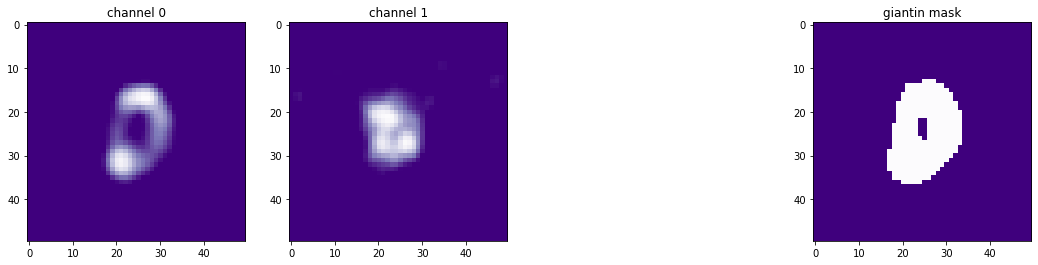

(349.484, 349.5048)
4
Area of contour too small: 0.5
5
Area of contour too small: 0.0
6
Area of contour too small: 7.0
7
Area of contour too small: 34.0
8
440 702


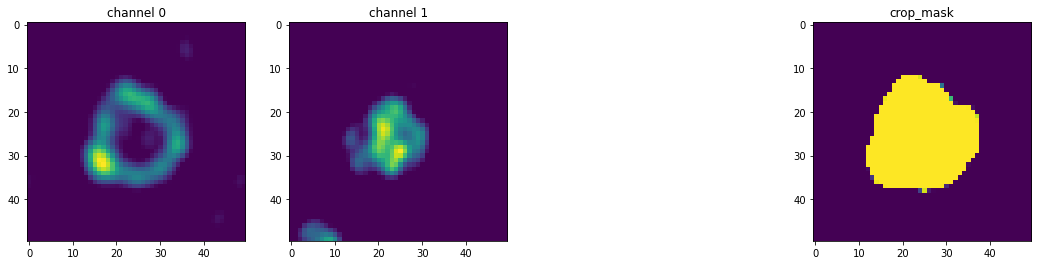

Circle match: 0.01711884919371154
circularity is 0.8078310009530212
ratio of minAreaRect :0.9290779682031375
ratio of minEnclosingCircle :0.753406510666754
ratio of boundingRect :0.6894586894586895
circle: 0.01711884919371154
ellipse: 0.38848400435971386


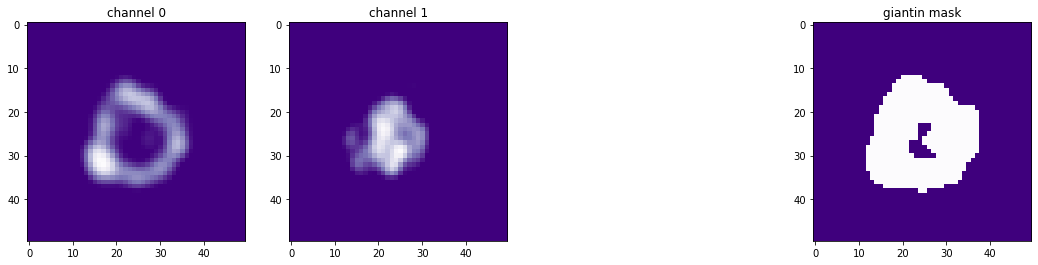

(349.5117, 349.4982)
9
455 623


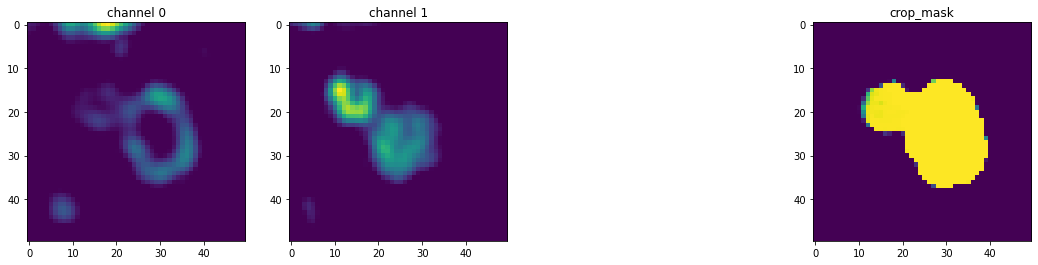

crop had convex, and not satisfied.


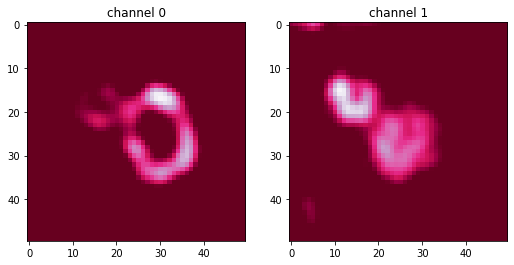

10
296 620


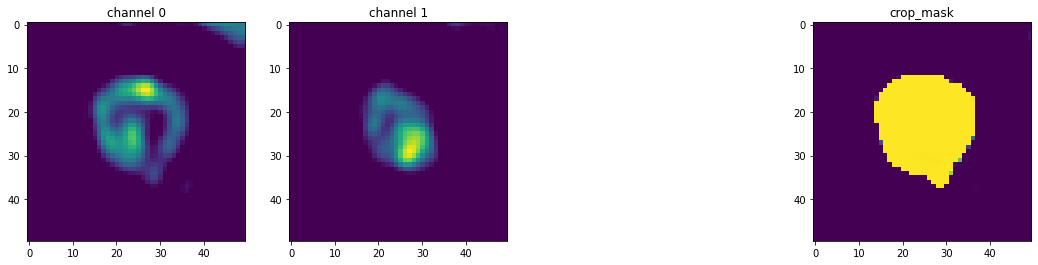

Circle match: 0.013804589421025026
circularity is 0.8111816492989081
ratio of minAreaRect :0.9999998327466224
ratio of minEnclosingCircle :0.7322568942662023
ratio of boundingRect :0.6797658862876255
circle: 0.013804589421025026
ellipse: 0.36891284602618746


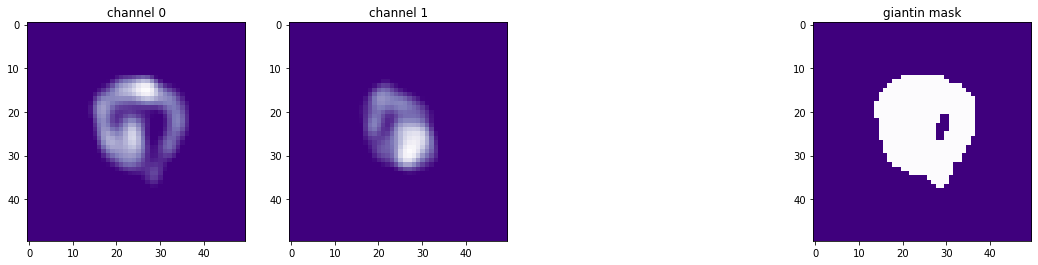

(349.4858, 349.5143)
11
337 593


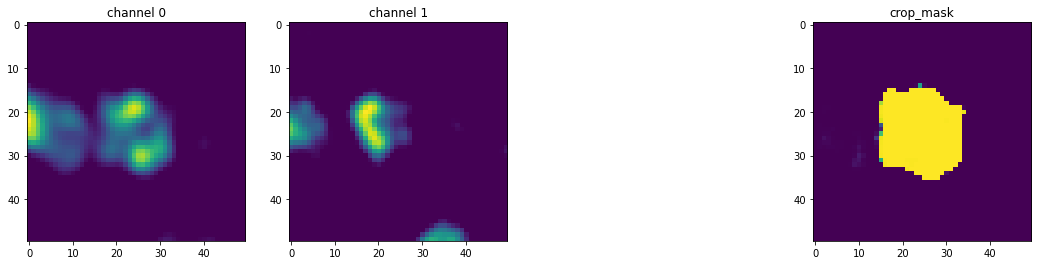

KeyboardInterrupt: 

In [281]:
from functions import check_contours, cal_gyradius, cal_center_of_mass, shift_make_border, normalize_total_intensity

golgi_image = golgi_image_list[k].transpose((1, 2, 0))
pred_mask = unpad_mask_list[k]
finished_golgi_list = []
target_size = 701
center_coordinate = (350, 350)
for i, contour in enumerate(contours):
    print(i)
    contourArea = cv2.contourArea(contour)
    if cv2.contourArea(contour) < contour_area_threshold:
        print("Area of contour too small: {}".format(contourArea))
        continue
    rect_size = 50
    sub_list = None
    for _ in range(2):
        crop_golgi, flag, sub_list = check_contours(golgi_image, pred_mask, contour,
                                                    giantin_channel=giantin_channel,
                                                    min_giantin_area=contour_area_threshold, sub_list=sub_list,
                                                    giantin_possibility_threshold=giantin_possibility_threshold,
                                                    rect_size=rect_size,
                                                    show_plt=True, overlapping=False)
        if flag:
            crop_giantin = crop_golgi[:, :, giantin_channel]
            mx, my = cal_center_of_mass(crop_giantin)
            gyradius = cal_gyradius(crop_giantin, mx, my)
            if rect_size > gyradius * target_size / 100:
                rect_size = int(gyradius * target_size / 100)
                print("new rect_size: {}".format(rect_size))
                continue
            else:
                new_size = [int(size * 100 / gyradius) for size in crop_giantin.shape]
                resized_golgi = cv2.resize(crop_golgi, new_size, interpolation=cv2.INTER_LINEAR)
                normalized_golgi = normalize_total_intensity(resized_golgi, target_total_intensity=200000000)
                shifted_golgi = shift_make_border(normalized_golgi, border_size=(target_size, target_size),
                                                  center_coord=center_coordinate, giantin_channel=giantin_channel)
                finished_golgi_list.append(shifted_golgi)
                break
        else:
            break

666 979


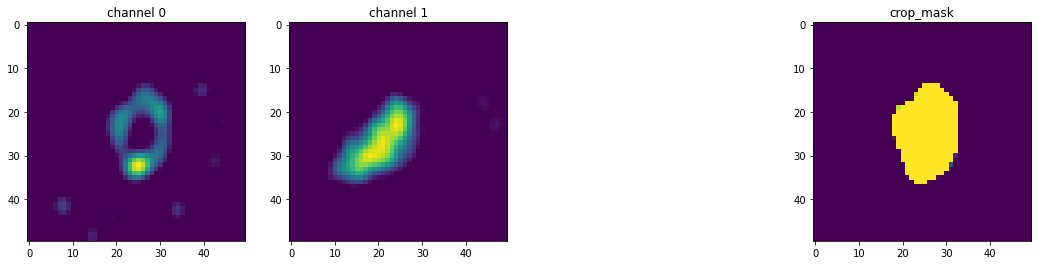

Circle match: 0.07994021744006807
circularity is 0.7817598710595909
ratio of minAreaRect :0.6363636363636364
ratio of minEnclosingCircle :0.5765747073071569
ratio of boundingRect :0.6681159420289855
circle: 0.07994021744006807
ellipse: 0.1398613484116844


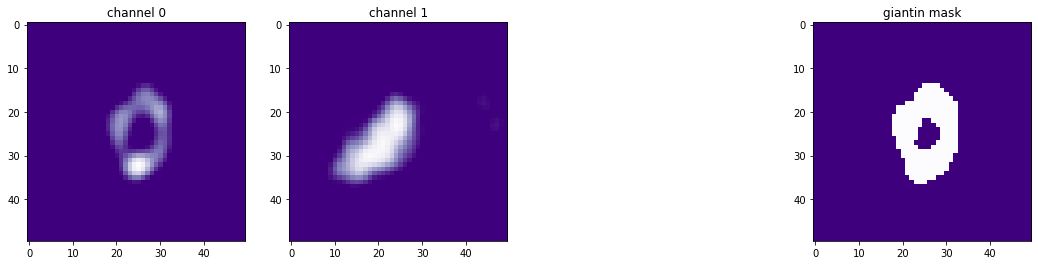

666 979


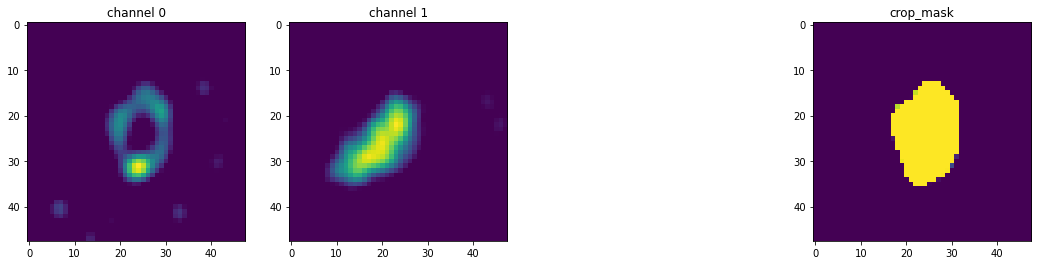

Circle match: 0.0799402174400703
circularity is 0.7817598710595909
ratio of minAreaRect :0.6363636363636364
ratio of minEnclosingCircle :0.5765747073071569
ratio of boundingRect :0.6681159420289855
circle: 0.0799402174400703
ellipse: 0.1398613484116834


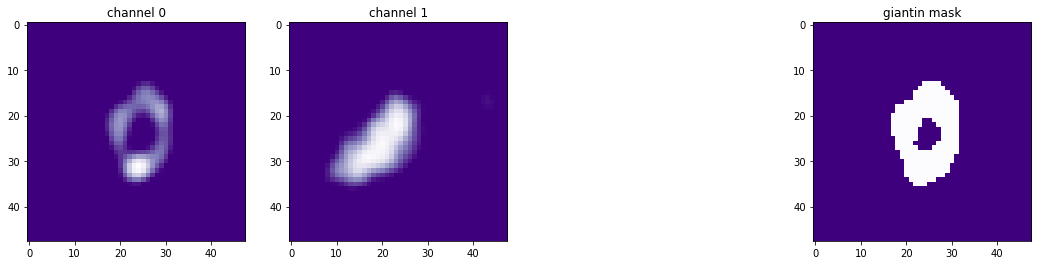

(349.4916, 349.4844)


In [308]:
# TEST ONE CONTOUR.
from functions import check_contours, cal_gyradius, cal_center_of_mass, shift_make_border, normalize_total_intensity

golgi_image = golgi_image_list[k].transpose((1, 2, 0))
pred_mask = unpad_mask_list[k]
target_size = 701
center_coordinate = (350, 350)
rect_size = 50
sub_list = None
finished_golgi_list = []
for _ in range(2):
    crop_golgi, giantin_contour, flag, sub_list = check_contours(golgi_image, pred_mask, contours[0],
                                                                 giantin_channel=giantin_channel,
                                                                 min_giantin_area=contour_area_threshold,
                                                                 sub_list=sub_list,
                                                                 giantin_possibility_threshold=giantin_possibility_threshold,
                                                                 rect_size=rect_size,
                                                                 show_plt=True, overlapping=False)
    if flag:
        crop_giantin = crop_golgi[:, :, giantin_channel]
        mx, my = cal_center_of_mass(crop_giantin, giantin_contour)
        gyradius = cal_gyradius(crop_giantin, mx, my)
        if rect_size > gyradius * target_size / 100:
            rect_size = int(gyradius * target_size / 100)
            continue
        new_size = [int(size * 100 / gyradius) for size in crop_giantin.shape]
        resized_golgi = cv2.resize(crop_golgi, new_size, interpolation=cv2.INTER_LINEAR)
        normalized_golgi = normalize_total_intensity(resized_golgi, target_total_intensity=200000000)
        shifted_golgi = shift_make_border(normalized_golgi, border_size=(target_size, target_size),
                                          center_coord=center_coordinate, giantin_channel=giantin_channel)
        finished_golgi_list.append(shifted_golgi)
        break
    else:
        break

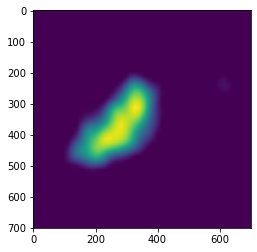

In [310]:
plt.imshow(shifted_golgi[:, :, 1])

In [118]:
tifffile.imsave(data=pred_mask, file="pred_mask.tif")

In [144]:
finished_golgi_list = np.array(finished_golgi_list)

In [145]:
mean_golgi = np.mean(finished_golgi_list, axis=0)
print(mean_golgi.shape)

(701, 701, 2)


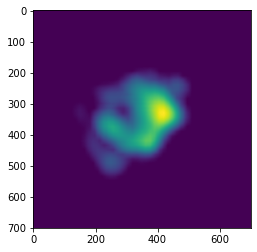

In [146]:
plt.imshow(mean_golgi[:, :, 0])

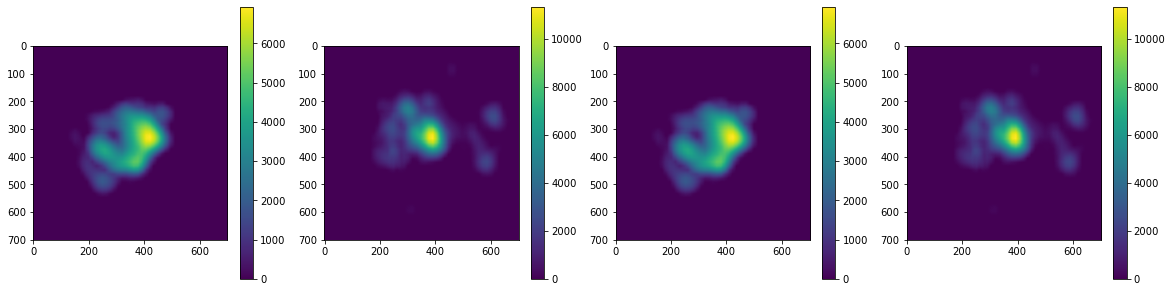

In [378]:
fig = mean_golgi
f = plt.figure(figsize=(20, 5))
ax = plt.subplot(141)
a = plt.imshow(fig[:, :, 0])
plt.colorbar(a, ax=ax)

ax = plt.subplot(142)
b = plt.imshow(fig[:, :, 1])
plt.colorbar(b, ax=ax)
ax = plt.subplot(143)

a = plt.imshow(fig[:, :, 0])
plt.colorbar(a, ax=ax)

ax = plt.subplot(144)
b = plt.imshow(fig[:, :, 1])
plt.colorbar(b, ax=ax)
# plt.subplot(133)
# plt.imshow(fig[:, :, 2])
plt.show()

In [69]:
from functions import cal_radial_mean_intensity

df_list = cal_radial_mean_intensity(fig)

chennel 0 finished
chennel 1 finished


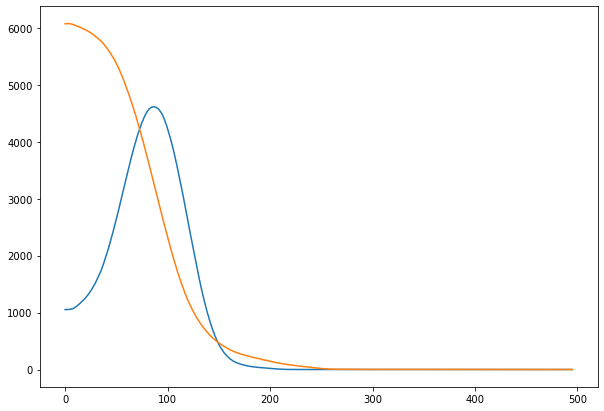

In [70]:
plt.figure(figsize=(10, 7))
ax = plt.axes()
ax.plot(df_list[0]['mean_intensity'])
ax.plot(df_list[1]['mean_intensity'])
# ax.plot(df_list[2]['mean_intensity'])

In [405]:
import pandas as pd

data = np.array(pd.read_csv("../try/try1.csv"))

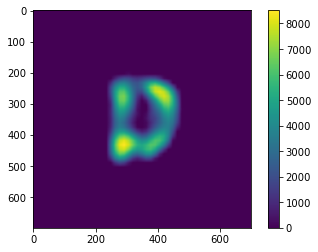

In [406]:
plt.imshow(data)
plt.colorbar()

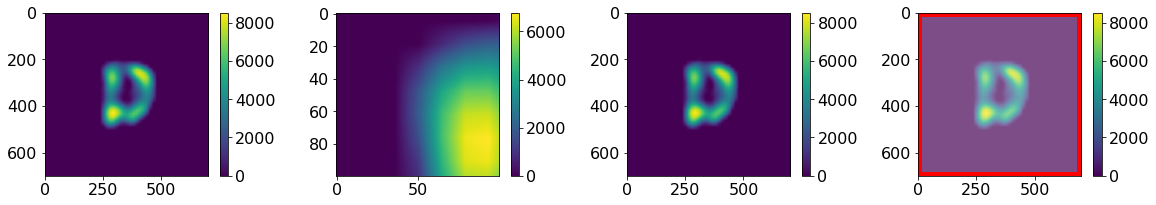

In [453]:
from matplotlib.patches import Rectangle

fig = mean_golgi
plt.figure(figsize=(20, 3))
ax = plt.subplot(141)
a = plt.imshow(data)
plt.colorbar(a, ax=ax)

ax = plt.subplot(142)
b = plt.imshow(data[200:300, 200:300])
plt.colorbar(b, ax=ax)
ax = plt.subplot(143)

a = plt.imshow(data)
plt.colorbar(a, ax=ax)

ax = plt.subplot(144)
b = plt.imshow(data)
ax.add_patch(Rectangle((0.5, 0.5,), 700, 700, facecolor="white", alpha=0.3))
ax.add_patch(Rectangle((-0.5, -0.5), 700, 700, fill=False, edgecolor="red", linewidth=8))
plt.colorbar(b, ax=ax)
# plt.subplot(133)
# plt.imshow(fig[:, :, 2])
plt.show()

In [424]:
xx = np.array([134, 51345, 0])

np.where(xx == 0, 300, xx)

array([  134, 51345,   300])